In [1]:
import json
import joblib
from pprint import pprint
from pathlib import Path

import pandas as pd
import numpy as np
import polars as pl

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

import lightgbm as lgb
from lightgbm.callback import log_evaluation, early_stopping

from isic_helper import DotDict
from isic_helper import get_folds
from isic_helper import compute_auc, compute_pauc

pd.options.display.max_columns = 1000

In [2]:
cfg = DotDict()
cfg.seed = 2022

cfg.models_output_dir = "models"
cfg.model_name = "lgb_v4"

In [3]:
INPUT_PATH = Path("/kaggle/input/isic-2024-challenge/")
MODELS_OUTPUT_PATH = Path(f"{cfg.models_output_dir}")
MODELS_OUTPUT_PATH.mkdir(exist_ok=True)

id_column = "isic_id"
target_column = "target"
group_column = "patient_id"

In [4]:
numerical_features = [
    "age_approx", 
    "clin_size_long_diam_mm",
    "tbp_lv_A", "tbp_lv_Aext",
    "tbp_lv_B", "tbp_lv_Bext",
    "tbp_lv_C", "tbp_lv_Cext",
    "tbp_lv_H", "tbp_lv_Hext",
    "tbp_lv_L", "tbp_lv_Lext",
    "tbp_lv_areaMM2",
    "tbp_lv_area_perim_ratio",
    "tbp_lv_color_std_mean",
    "tbp_lv_deltaA", "tbp_lv_deltaB", "tbp_lv_deltaL", "tbp_lv_deltaLB", "tbp_lv_deltaLBnorm",
    "tbp_lv_eccentricity",
    "tbp_lv_minorAxisMM",
    "tbp_lv_nevi_confidence",
    "tbp_lv_norm_border", "tbp_lv_norm_color",
    "tbp_lv_perimeterMM",
    "tbp_lv_radial_color_std_max",
    "tbp_lv_stdL", "tbp_lv_stdLExt",
    "tbp_lv_symm_2axis", "tbp_lv_symm_2axis_angle",
    "tbp_lv_x", "tbp_lv_y", "tbp_lv_z",
]

ord_categorical_features = [
    "sex", 
    "anatom_site_general", 
    "tbp_tile_type", 
    "tbp_lv_location", 
    "tbp_lv_location_simple",
    "attribution", 
    "copyright_license"
]

In [5]:
def read_data(path, is_train=True):
    df = pl.read_csv(path, 
                     schema_overrides={"age_approx": pl.Float32}, 
                     null_values=["NA"])
    df = df.rename({"age_approx": "age"})
    if is_train:
        folds_df = pl.read_csv(path.parent.parent / "isic-scd-folds/folds.csv")
        df = df.join(folds_df, on=[id_column , group_column], how="left")
    return df

def feature_engineering(df):
    df = df.join(
        df.group_by(group_column).agg(pl.col("age").max().alias("age_approx")),
        on=group_column,
        how="left"
    ).drop("age")
#     df = df.with_columns(
#         pl.concat_str(
#             [pl.col("sex"), pl.col("age_approx").cast(pl.Utf8).fill_null("NA")]
#         ).alias("sex_age_approx")
#     )
    df = df.with_columns(
        lesion_size_ratio = pl.col('tbp_lv_minorAxisMM') / pl.col('clin_size_long_diam_mm')
    ).with_columns(
        ((pl.col("lesion_size_ratio") - pl.col("lesion_size_ratio").mean().over(group_column)) / (pl.col("lesion_size_ratio").std().over(group_column) + 1e-5)).alias("lesion_size_ratio_norm")
    ).drop("lesion_size_ratio")
    return df.to_pandas()

def get_encoder_and_fit(df, num_cols, ord_cat_cols, ohe_cat_cols):
    mixed_encoded_preprocessor = ColumnTransformer(
    [
        ("numerical", "passthrough", num_cols),
        (
            "ord_categorical",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-2, encoded_missing_value=-1, dtype=int),
            ord_cat_cols,
        ),
        (
            "ohe_categorical",
            OneHotEncoder(sparse_output=False, dtype=np.int32, handle_unknown="ignore"),
            ohe_cat_cols
        )
    ],
    verbose_feature_names_out=False,

    )
    mixed_encoded_preprocessor.set_output(transform="pandas")
    
    mixed_encoded_preprocessor.fit(df)
    return mixed_encoded_preprocessor
    

In [6]:
train = read_data(INPUT_PATH / "train-metadata.csv")
test = read_data(INPUT_PATH / "test-metadata.csv", is_train=False)

In [7]:
train = feature_engineering(train)
test = feature_engineering(test)

In [8]:
numerical_features += [
    "lesion_size_ratio_norm"
]

ord_categorical_features += []

In [9]:
encoder = get_encoder_and_fit(train, numerical_features, ord_categorical_features, [])
with open(f"{cfg.model_name}_encoder.joblib", "wb") as f:
    joblib.dump(encoder, f)

In [10]:
categorical_features = ord_categorical_features + ["age_approx"]

In [11]:
X_train = encoder.transform(train)
X_test = encoder.transform(test)

train_ids = train[id_column]
y_train = train[target_column]
groups = train[group_column]
folds = train["fold"]

print(f"Total number of columns: {len(X_train.columns)}")

Total number of columns: 42


In [12]:
def pauc_80(preds, data):
    score_value = compute_pauc(data.get_label(), preds, min_tpr=0.8)   
    return "pauc_80", score_value, True


params = {
    "objective": "binary",
    "metric": "custom",
    "metric_freq": 10,
    "num_leaves": 63,
    "learning_rate": 0.01,
    "bagging_freq": 6,
    "bagging_fraction": 0.6,
    "bagging_seed": cfg.seed,
    "feature_fraction": 0.3,
    "feature_fraction_seed": cfg.seed,
    "lambda_l1": 0.95,
    "lambda_l2": 0.95,
    "verbosity": -1
}
num_rounds = 3000
es_rounds = 250
log_rounds = 50

In [13]:
best_num_rounds = {}
val_auc_scores = {}
val_pauc_scores = {}
all_folds = np.sort(folds.unique())
oof_predictions = np.zeros(X_train.shape[0])
for fold in all_folds:
    print(f"Running fold: {fold}")
    dev_index = folds[folds != fold].index
    val_index = folds[folds == fold].index
    
    X_dev = X_train.loc[dev_index, :]
    y_dev = y_train[dev_index]
    
    X_val = X_train.loc[val_index, :]
    y_val = y_train[val_index]
    
    lgb_dataset_dev = lgb.Dataset(X_dev, label=y_dev, categorical_feature=categorical_features, free_raw_data=False)
    lgb_dataset_val = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(
        params,
        lgb_dataset_dev,
        num_boost_round=num_rounds,
        valid_sets=[lgb_dataset_val],
        feval=pauc_80,
        callbacks=[early_stopping(stopping_rounds=es_rounds), log_evaluation(log_rounds)],
    )
    
    model.save_model(MODELS_OUTPUT_PATH / f"{cfg.model_name}_fold_{fold}.txt")
    best_num_rounds[f"fold_{fold}"] = model.best_iteration
    val_scores = dict(model.best_score["valid_0"])
    
    val_preds = model.predict(X_val, num_iteration=model.best_iteration)
    oof_predictions[val_index] = val_preds
    
    val_auc_scores[f"fold_{fold}"] = compute_auc(y_val, val_preds)
    val_pauc_scores[f"fold_{fold}"] = val_scores["pauc_80"]
    print("\n")

print("Val AUC scores:")
pprint(val_auc_scores)
print("Val PAUC scores:")
pprint(val_pauc_scores)

oof_preds_df = pd.DataFrame({
    id_column: train_ids,
    group_column: groups,
    "fold": folds,
    target_column: y_train,
    f"oof_{cfg.model_name}": oof_predictions
})
oof_preds_df.to_csv(f"oof_preds_{cfg.model_name}.csv", index=False)

cv_auc_oof = compute_auc(oof_preds_df[target_column], oof_preds_df[f"oof_{cfg.model_name}"])
cv_pauc_oof = compute_pauc(oof_preds_df[target_column], oof_preds_df[f"oof_{cfg.model_name}"], min_tpr=0.8)

cv_auc_avg = np.mean(list(val_auc_scores.values()))
cv_pauc_avg = np.mean(list(val_pauc_scores.values()))

cv_auc_std = np.std(list(val_auc_scores.values()))
cv_pauc_std = np.std(list(val_pauc_scores.values()))

print(f"CV AUC OOF: {cv_auc_oof}")
print(f"CV PAUC OOF: {cv_pauc_oof}")
print(f"CV AUC AVG: {cv_auc_avg}")
print(f"CV PAUC AVG: {cv_pauc_avg}")
print(f"CV AUC STD: {cv_auc_std}")
print(f"CV PAUC STD: {cv_pauc_std}")
print(X_train.columns)

Running fold: 1
Training until validation scores don't improve for 250 rounds
[50]	valid_0's pauc_80: 0.153134
[100]	valid_0's pauc_80: 0.153442
[150]	valid_0's pauc_80: 0.157231
[200]	valid_0's pauc_80: 0.157571
[250]	valid_0's pauc_80: 0.158142
[300]	valid_0's pauc_80: 0.16086
[350]	valid_0's pauc_80: 0.162369
[400]	valid_0's pauc_80: 0.163199
[450]	valid_0's pauc_80: 0.163319
[500]	valid_0's pauc_80: 0.163455
[550]	valid_0's pauc_80: 0.163845
[600]	valid_0's pauc_80: 0.163895
[650]	valid_0's pauc_80: 0.16317
[700]	valid_0's pauc_80: 0.163148
[750]	valid_0's pauc_80: 0.163137
[800]	valid_0's pauc_80: 0.163664
Early stopping, best iteration is:
[594]	valid_0's pauc_80: 0.16413


Running fold: 2
Training until validation scores don't improve for 250 rounds
[50]	valid_0's pauc_80: 0.14039
[100]	valid_0's pauc_80: 0.143646
[150]	valid_0's pauc_80: 0.148591
[200]	valid_0's pauc_80: 0.151807
[250]	valid_0's pauc_80: 0.153481
[300]	valid_0's pauc_80: 0.155089
[350]	valid_0's pauc_80: 0.1556

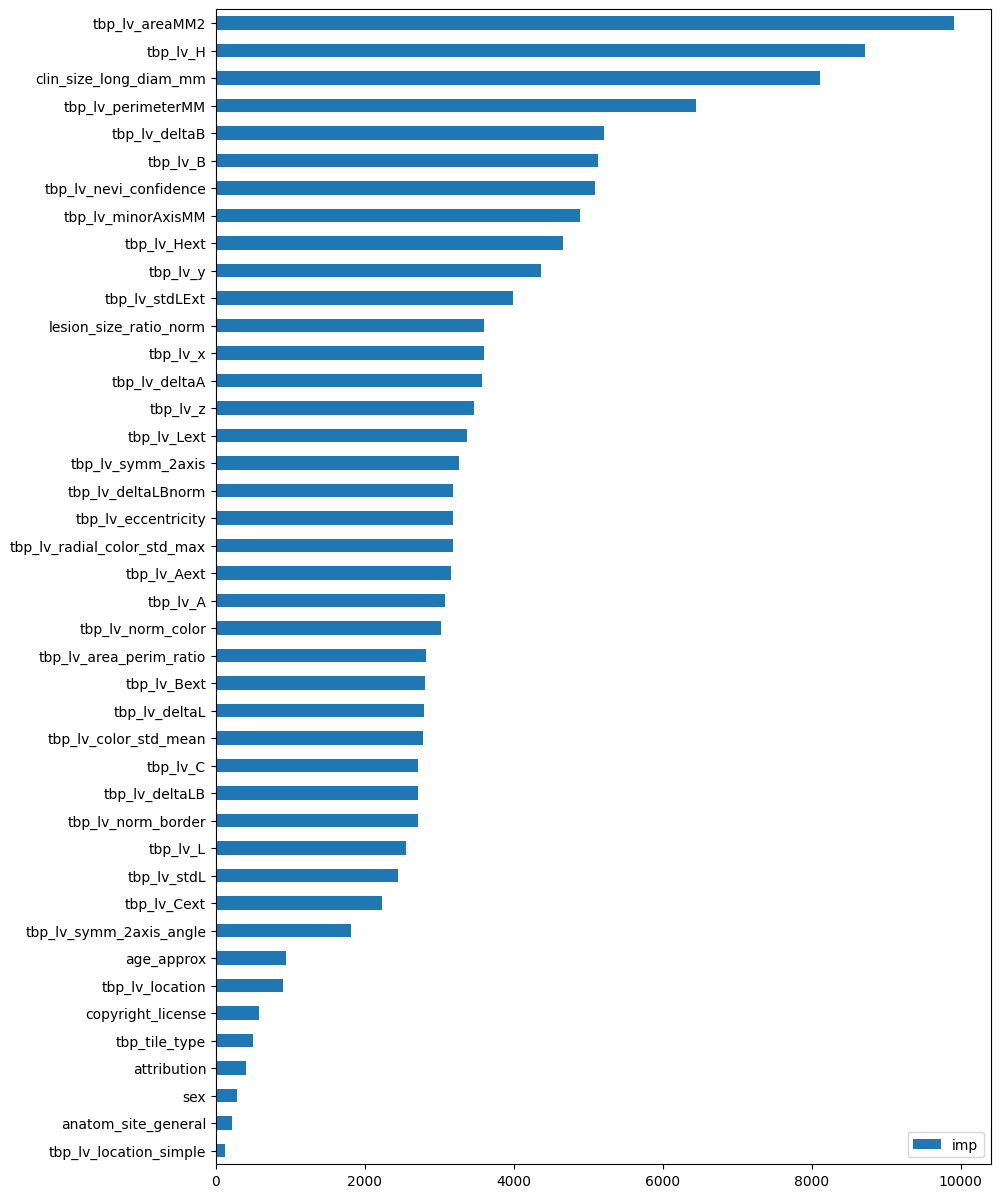

In [14]:
feature_importances = 0
for fold in all_folds:
    model = lgb.Booster(model_file=MODELS_OUTPUT_PATH / f"{cfg.model_name}_fold_{fold}.txt")
    if fold == 1:
        feature_names = model.feature_name()
    feature_importances += model.feature_importance(importance_type="gain")
feature_importances /= len(all_folds)

imp = pd.DataFrame.from_dict(dict(zip(feature_names, feature_importances)), 
                             orient="index", columns=["imp"]).sort_values("imp", ascending=True)
imp.plot(kind="barh", figsize=(10, 15))

metadata = {
    "params": params,
    "num_rounds": num_rounds,
    "es_rounds": es_rounds,
    "best_num_rounds": best_num_rounds,
    "val_auc_scores": val_auc_scores,
    "val_pauc_scores": val_pauc_scores,
    "cv_auc_oof": cv_auc_oof,
    "cv_pauc_oof": cv_pauc_oof,
    "cv_auc_avg": cv_auc_avg,
    "cv_pauc_avg": cv_pauc_avg
}

with open(f"{cfg.model_name}_run_metadata.json", "w") as f:
    json.dump(metadata, f)